In [1]:
!pip install --quiet pandas numpy matplotlib scipy nltk

In [3]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from scipy import stats
from math import radians, cos, sin, asin, sqrt, atan2
try:
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
except:
    import nltk
    nltk.download('vader_lexicon')
    from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re

In [4]:
sid = SentimentIntensityAnalyzer()

In [59]:
dirty = pd.read_csv("29893909_dirty_data.csv")
missing = pd.read_csv("29893909_missing_data.csv")
outlier = pd.read_csv("29893909_outlier_data.csv")
warehouses = pd.read_csv("warehouses.csv")

In [6]:
dirty

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD325335,ID0575552807,2019-01-10,Nickolson,"[('Olivia x460', 1), ('Alcon 10', 1), ('iStrea...",12505,66.21,-37.826274,144.985765,10,11320.71,Summer,False,1.6624,"nunca llego el producto, ustedes me estafaron ...",False
1,ORD198330,ID6167266608,2019-03-22,Nickolson,"[('Olivia x460', 2), ('Universe Note', 1), ('T...",17030,79.64,144.965957,-37.814528,10,15406.64,Autumn,True,0.5521,great product this is great i love it! but one...,True
2,ORD055763,ID6167441014,2019-29-01,Thompson,"[('Toshika 750', 1), ('Thunder line', 2)]",8680,98.03,-37.807066,144.960036,10,7910.03,Summer,True,1.3001,great!!! great!!!,True
3,ORD474045,ID0202772778,2019-07-01,Thompson,"[('Alcon 10', 1), ('Universe Note', 1)]",12400,53.87,-37.808333,144.935175,10,11213.87,spring,False,1.1522,bad phone quit within 4 months.,False
4,ORD250150,ID0711328221,2019-11-25,Thompson,"[('Toshika 750', 2), ('iStream', 1), ('Candle ...",18600,103.97,-37.807921,144.957742,0,18703.97,Spring,True,1.0775,five stars i love this phone...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORD236215,ID0443302596,2019-04-13,Bakers,"[('Olivia x460', 1), ('Lucent 330S', 2)]",3685,51.47,-37.813345,145.005667,0,3736.47,Autumn,False,0.9905,basic phone very basic no frills phone. it's a...,False
496,ORD237119,ID0577522375,2019-27-06,Nickolson,"[('Toshika 750', 2), ('Universe Note', 2)]",15540,63.35,-37.822822,144.970888,15,13272.35,Winter,False,0.4850,love it! as always xiaomidevices are always gr...,True
497,ORD185754,ID2776396932,2019-02-08,Nickolson,"[('iAssist Line', 1), ('iStream', 1), ('Lucent...",4035,76.97,-37.812862,144.964225,0,4111.97,Summer,True,0.7916,problemas cuando esta bloqueado y entra una ll...,False
498,ORD078318,ID0452381035,2019-11-26,thompson,"[('Alcon 10', 1), ('iStream', 1), ('iAssist Li...",14775,105.15,-37.824950,144.949013,10,13402.65,Spring,True,1.3772,this phone is great. i purchased this phone as...,True


In [11]:
warehouse_names = ["Nickolson", "Thompson", "Bakers"]

In [12]:
wh_locations = [np.array(((warehouses["lat"][i], warehouses["lon"][i]))) for i in warehouses.index]

,names,lat,lon
0,Nickolson,-37.818595,144.969551
1,Thompson,-37.812673,144.947069
2,Bakers,-37.809996,144.995232


In [13]:
def distance(p1, p2):
    lat1, lon1 = p1
    lat2, lon2 = p2
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    R = 6378

    distance = R * c
    return distance

In [14]:
# It is observed that there are certain points where the latitudes and longitudes have been interchanged
print(dirty.customer_long.max(), dirty.customer_long.min())
print(dirty.customer_lat.max(), dirty.customer_lat.min())

145.01771630000005 -37.824382299999996
145.010299 -37.832478


In [8]:
for index in dirty.index:
    lat = dirty.loc[index, "customer_lat"]
    lon = dirty.loc[index, "customer_long"]
    
    # Handling cases with interchanged latitudes and longitudes
    if (lat > 100) or (lon < 30):
        dirty.loc[index, "customer_lat"] = lon
        dirty.loc[index, "customer_long"] = lat 
        
    # Nearest warehouse
    coordinate = np.array((lat, lon))
    distances = [distance(i, coordinate) for i in wh_locations]
    min_dist = round(min(distances), 4)
    if min_dist !=  dirty.loc[index, 'distance_to_nearest_warehouse']:
        dirty.loc[index, 'distance_to_nearest_warehouse'] = min_dist
    
    dirty.loc[index, 'nearest_warehouse'] = warehouse_names[distances.index(min(distances))]

NameError: name 'wh_locations' is not defined

From the following cell, it is clear that even though distance_to_nearest_warehouse is correct in many cases, nearest_warehouse is not

In [19]:
for index in dirty.index[:10]:
    coordinate = np.array((lat, lon))
    distances = [round(distance(i, coordinate), 4) for i in wh_locations]
    min_dist = round(min(distances), 4)
    if min_dist !=  dirty.loc[index, 'distance_to_nearest_warehouse']:
        dirty.loc[index, 'distance_to_nearest_warehouse'] = min_dist
    
    nw = warehouse_names[distances.index(min(distances))]
    
    if dirty.loc[index, 'nearest_warehouse'] != nw:
        print(dirty.loc[index, 'nearest_warehouse'], nw)
        print(dirty.loc[index, 'distance_to_nearest_warehouse'], min(distances))

Thompson Nickolson
113.7174 113.7174
Thompson Nickolson
113.7174 113.7174
Thompson Nickolson
113.7174 113.7174
Thompson Nickolson
113.7174 113.7174
Thompson Nickolson
113.7174 113.7174
Thompson Nickolson
113.7174 113.7174
Bakers Nickolson
113.7174 113.7174
Thompson Nickolson
113.7174 113.7174


There are datapoints with inaccurate sentiments, i.e., is_happy_customer

In [21]:
for index in dirty.index[:100]:
    try:
        polarity = sid.polarity_scores(dirty.loc[index, 'latest_customer_review'])['compound']
        if polarity > 0:
            happy = True
        else:
            happy = False
        if happy != bool(dirty.loc[index, 'is_happy_customer']):
            print(happy, dirty.loc[index, 'latest_customer_review'])
    except:
        pass

True five stars i love this phone...
False None
True i bought this for my dad in his late 60s mainly to listen to music and read ebooks borrowed from the library. i set it up for him and he loves it. i just don't like that it has ads on the start up unless you pay to get rid of them.
False one star this phone is not unlocked at all...
True five stars excellent
False one star more damage to device then was disclosed


The following cell fixes the errors that have been identified above

In [65]:
seasons = {
    1: "Summer",
    2: "Summer",
    3: "Autumn",
    4: "Autumn",
    5: "Autumn",
    6: "Winter",
    7: "Winter",
    8: "Winter",
    9: "Spring",
    10: "Spring",
    11: "Spring",
    12: "Summer",
}

for index in dirty.index:
    try:
        polarity = sid.polarity_scores(dirty.loc[index, 'latest_customer_review'])['compound']
        if polarity > 0:
            dirty.loc[index, 'is_happy_customer'] = True
        else:
            dirty.loc[index, 'is_happy_customer'] = False
            
        # Handling cases with interchanged latitudes and longitudes
        if (dirty.loc[index, 'customer_lat'] > 100) or (dirty.loc[index, 'customer_long'] < 30):
            lat = dirty.loc[index, "customer_lat"]
            lon = dirty.loc[index, "customer_long"]
            dirty.loc[index, "customer_lat"] = lon
            dirty.loc[index, "customer_long"] = lat

        # Ensuring that season and nearest_warehouse have consistent capitalization
        date = dirty.loc[index, 'date']
        try:
            season = seasons[pd.to_datetime(date, format="%Y-%m-%d").month]
        except:
            if re.match("[0-3][0-9]-[0-1][0-9]-[0-9][0-9][0-9][0-9]", date):
                season = seasons[pd.to_datetime(date, format="%d-%m-%Y").month]
            else:
                season = seasons[pd.to_datetime(date, format="%Y-%d-%m").month]
        dirty.loc[index, 'season'] = season
        
        dirty.loc[index, 'nearest_warehouse'] = dirty.loc[index, 'nearest_warehouse'].capitalize()

        # Ensuring that order_total = order_price + delivery_charges - coupon_discount
        dc = dirty.loc[index, 'delivery_charges']
        op = dirty.loc[index, 'order_price']
        cd = dirty.loc[index, 'coupon_discount']
        ot = dirty.loc[index, 'order_total']
        if not (ot == (dc + op - cd)):
            dirty.loc[index, 'order_total'] = dc + op - cd
    except Exception as e:
        print(index, e)
        dirty.loc[index]
        
        pass

# Outlier Analysis

All the points that lie beyond 3 standard deviations away from the mean are consdiered to be outliers.

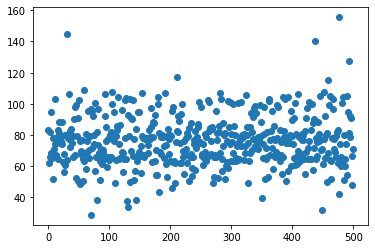

In [12]:
plt.scatter([_ for _ in range(500)], outlier.delivery_charges)

In [15]:
outliers_delivery_charges

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
31,ORD046343,ID0579391888,2019-12-06,Nickolson,"[('iAssist Line', 2), ('Toshika 750', 1)]",8770,144.915,-37.821683,144.956248,25,6722.415,Summer,True,1.2192,i have never been more satisfied with a produc...,True
437,ORD167361,ID0122741155,2019-01-09,Nickolson,"[('Olivia x460', 1), ('Alcon 10', 1)]",10175,140.250,-37.822161,144.960781,25,7771.500,Summer,True,0.8673,great phone is great phone and i love it.,True
476,ORD102449,ID1463620745,2019-11-30,Bakers,"[('Universe Note', 1), ('pearTV', 2), ('Candle...",16500,155.490,-37.816779,145.005593,0,16655.490,Spring,True,1.1833,"easy to use phone is very easy to learn, espec...",True
493,ORD270575,ID0250933633,2019-04-04,Bakers,"[('Toshika 750', 1), ('Lucent 330S', 2), ('pea...",13090,127.560,-37.825964,145.004760,15,11254.060,Autumn,True,1.9651,"great, especially for price!! only had it for ...",True


Looking for outliers in location

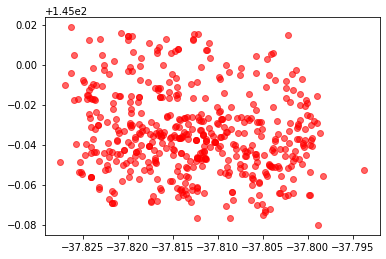

In [25]:
import matplotlib.pyplot as plt
plt.scatter(outlier.customer_lat, outlier.customer_long, color='red', alpha=0.6)

From the following plot, it is evident that there are several outliers wrt delivery_chartes

<AxesSubplot:>

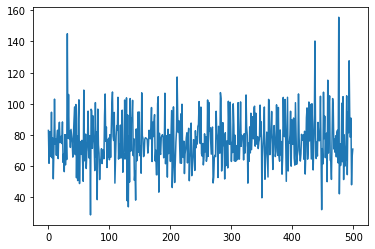

In [26]:
outlier.delivery_charges.plot()

In [34]:
outlier.delivery_charges.describe()

count    500.000000
mean      76.437460
std       16.255986
min       28.665000
25%       65.637500
50%       76.105000
75%       83.927500
max      155.490000
Name: delivery_charges, dtype: float64

In [46]:
outlier_delivery_100 = outlier[outlier.delivery_charges>100]
warehouses

,names,lat,lon
0,Nickolson,-37.818595,144.969551
1,Thompson,-37.812673,144.947069
2,Bakers,-37.809996,144.995232


Here, we visualize outlier datapoints wrt delivery charges (>100) in green while warehouses are depicted by blue points.

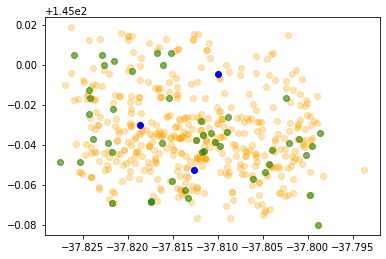

In [53]:
plt.scatter(outlier.customer_lat, outlier.customer_long, color='orange', alpha=0.3)
plt.scatter(outlier_delivery_100.customer_lat, outlier_delivery_100.customer_long, color='green', alpha=0.5)
plt.scatter(warehouses.lat, warehouses.lon, color='blue') 

In [30]:
def outlier_numeric(df, Data):
    return df[np.abs(df[Data]-df[Data].mean()) > (3*df[Data].std())]

In [31]:
outliers_delivery_charges = outlier_numeric(outlier, 'delivery_charges')

In [33]:
outliers_delivery_charges.delivery_charges

31     144.915
437    140.250
476    155.490
493    127.560
Name: delivery_charges, dtype: float64

# Missing Values
Columns with no missing values
   * is_expedited_delivery
   * customer_lat
   * customer_long

In [60]:
def impute_mean(df, column):
    dataset = df.copy()
    dataset = dataset[[column]]
    dataset.fillna(dataset.mean(), inplace=True)
    df[column] = dataset[column]
    
    return df

In [61]:
missing = impute_mean(missing, "order_price")
missing = impute_mean(missing, "delivery_charges")

In [62]:
missing

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD470139,ID1842169016,2019-07-23,Nickolson,"[('iStream', 2), ('Olivia x460', 1)]",1525.0,53.870000,-37.832570,144.971684,15,1350.12,Winter,False,1.5670,blown speaker the speaker is terrible. when my...,0.0
1,ORD315411,ID0575434444,2019-08-08,Nickolson,"[('Lucent 330S', 2), ('Thunder line', 1)]",4640.0,77.328065,-37.819884,144.985301,0,4707.54,Winter,False,1.3924,works fine on t mobile and simple mobile netwo...,1.0
2,ORD227202,ID4633573541,2019-10-27,Thompson,"[('pearTV', 2), ('Universe Note', 2), ('Thunde...",23925.0,77.460000,-37.805484,144.943835,15,20413.71,Spring,False,0.8493,love it would reorder would reorder,1.0
3,ORD439324,ID2948774579,2019-05-15,Nickolson,"[('Lucent 330S', 2), ('iStream', 2), ('Thunder...",13890.0,68.040000,-37.807924,144.970436,25,10485.54,Autumn,False,1.1905,good phone it was a little more broken in than...,1.0
4,ORD166147,ID0060653715,2019-03-29,Thompson,"[('Candle Inferno', 2), ('pearTV', 1), ('iStre...",7320.0,63.030000,-37.819066,144.946629,5,7017.03,Autumn,True,0.7127,beware ridiculous paid 219 for a phone i had f...,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORD355229,ID0250933661,2019-12-06,Bakers,"[('iStream', 1), ('Thunder line', 1)]",2330.0,100.550000,-37.821835,145.003278,25,1848.05,Summer,True,1.4958,love the phone i just have one personal opinio...,1.0
496,ORD039745,ID0598347148,2019-09-27,Nickolson,"[('Toshika 750', 1), ('Lucent 330S', 2), ('Can...",9660.0,101.380000,-37.814088,144.963280,5,9278.38,Spring,True,0.7455,perfect phone the phone came in perfectly. i p...,1.0
497,ORD456121,ID0030944133,2019-09-18,Bakers,"[('Universe Note', 1), ('Thunder line', 2), ('...",12130.0,74.200000,-37.811000,144.991203,15,10384.70,Spring,False,0.3715,like it had been taken apart 2-3 the phone jus...,1.0
498,ORD326304,ID0103116463,2019-07-18,Thompson,"[('Thunder line', 1), ('Alcon 10', 2)]",20080.0,77.328065,-37.813045,144.955728,5,19152.41,Winter,True,0.7626,"great smartphone excellent cost benefit, batte...",1.0


In [18]:
for index in missing.index:
    # Compute is_happy_customer if missing
    if missing.loc[index, 'is_happy_customer'] not in [1.0, 0.0]:
        missing.loc[index, 'is_happy_customer'] = (sid.polarity_scores(missing.loc[index, 'latest_customer_review'])['compound'])
        
    # Compute order_total if missing
    dc = missing.loc[index, 'delivery_charges']
    op = missing.loc[index, 'order_price']
    cd = missing.loc[index, 'coupon_discount']
    ot = missing.loc[index, 'order_total']
    if not (ot == (dc + op - cd)):
        missing.loc[index, 'order_total'] = dc + op - cd
    ""

In [19]:
for index in missing.index:
    lat = missing.loc[index, "customer_lat"]
    lon = missing.loc[index, "customer_long"]
        
    # Nearest warehouse
    coordinate = np.array((lat, lon))
    distances = [distance(i, coordinate) for i in wh_locations]
    min_dist = round(min(distances), 4)
    missing.loc[index, 'distance_to_nearest_warehouse'] = min_dist
    
    missing.loc[index, 'nearest_warehouse'] = warehouse_names[distances.index(min(distances))]